# Image Classification With Transfer Learning Using Keras

# Task 1: Importing Libraries

In [1]:
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np
import pets

from matplotlib import pyplot as plt
%matplotlib inline

data_dir = 'data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.0.1
Is using GPU? False


# Task 2: Cats vs Dogs Dataset

In [2]:
pets.download_and_extract('data', '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


In [3]:
class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

train_annot, count_train = pets.cats_vs_dogs_annotations('data/annotations/trainval.txt')
test_annot, count_test = pets.cats_vs_dogs_annotations('data/annotations/test.txt')

print('Training examples: ', count_train)
print('Test examples: ', count_test)

Training examples:  3680
Test examples:  3669


# Task 3: Get Random Batch

In [4]:
image_dir = 'data/images/'

def get_random_batch(annot, batch_size = 4):
    all_keys = list(annot.keys())
    total_examples = len(all_keys)
    indices = np.random.choice(range(total_examples), batch_size, replace = 'False')
    x = np.zeros((batch_size, 128, 128, 3))
    y = np.zeros((batch_size, 1))
    images = []
    for i, idx in enumerate(indices):
        image_path = os.path.join(image_dir, all_keys[idx])
        image = tf.keras.preprocessing.image.load_img(image_path, target_size = (128, 128))
        arr = tf.keras.preprocessing.image.img_to_array(image)
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        arr = np.expand_dims(arr, axis = 0)
        x[i] = arr
        y[i] = class_to_index[annot[all_keys[idx]]]
        images.append(image)
    
    return x, y, images

Displaying first 8 examples..


<module 'matplotlib.pyplot' from 'c:\\users\\administrator\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

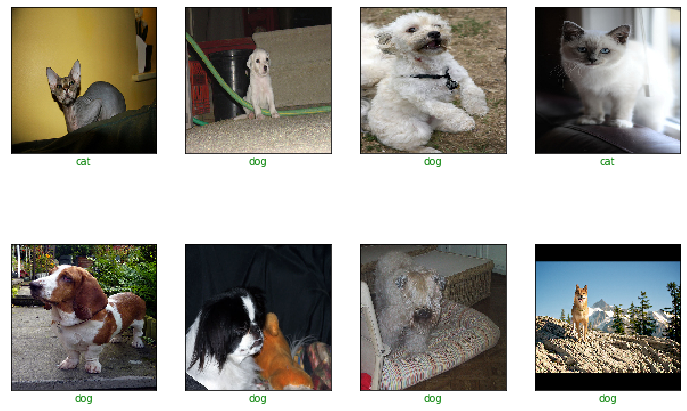

In [5]:
x, y, images = get_random_batch(train_annot, batch_size = 8)
pets.display_examples(x, y, y, images, index_to_class)

# Task 4: Create Model

In [6]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top = False, pooling = 'avg', weights = 'imagenet', input_shape = (128, 128, 3))
mnet.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [7]:
def create_model():
    model = tf.keras.models.Sequential([mnet, tf.keras.layers.Dropout(0.5), tf.keras.layers.Dense(1, activation = 'sigmoid')])
    model.layers[0].trainable = False
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


# Task 5: Model Training

In [8]:
def data_generator(batch_size, annot):
    while True:
        x, y, _ = get_random_batch(annot, batch_size)
        yield (x, y)

In [9]:
batch_size = 32
steps_per_epoch = int(count_train / batch_size)
validation_steps = int(count_test / batch_size)

print('Training steps: ', steps_per_epoch)
print('Validation steps: ', validation_steps)

Training steps:  115
Validation steps:  114


In [10]:
%%time

_ = model.fit_generator(
    data_generator(batch_size, train_annot),
    validation_data = data_generator(batch_size, test_annot),
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs = 1
)

115/115 [==============================] - 941s 8s/step - loss: 0.4840 - accuracy: 0.7772 - val_loss: 0.2142 - val_accuracy: 0.9315
Wall time: 15min 41s


# Task 6: Predictions

In [12]:
x, y, images = get_random_batch(test_annot, batch_size = 8)
preds = model.predict(x)

Displaying first 8 examples..


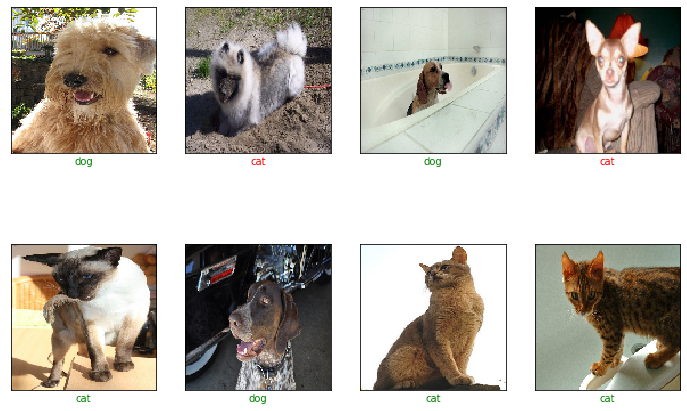

In [13]:
pets.display_examples(x, y, preds, images, index_to_class).show()